## Oppstart

In [1]:
from dhlab.module_update import update, css

In [2]:
css()

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Note that the file `nbtext.py` will be overwritten in the code below

This is probably ok, though. If not, change `update('nbtext', overwrite = True)` to `update('nbtext', overwrite = False)` and the file will stay unchanged. 


In [4]:
import dhlab.nbtext as nb
import dhlab.token_map as tm
from dhlab.nbtext import get_urn, make_graph, get_urn, relaterte_ord, navn, totals
import dhlab.graph_networkx_louvain as gnl
import pandas as pd
%matplotlib inline

plot = lambda x,  lw=3, alpha= 0.7: x.plot(figsize=(15,6), lw=lw, alpha=alpha)


In [17]:
from datetime import datetime

# Hjelpekommandoer

`alle_korpusnavn` henter ut alle navn (eller forslag til) fra korpuset.
`tell_navn` teller opp navnene på tvers av korpuset 


In [99]:
import pandas as pd

def alle_korpusnavn(korpus, ratio = 0.8, cutoff = 20):
    urner = list(korpus['urn'])
    alle_navn = tm.combine_names(tm.corpus_names(urner, ratio = ratio, cutoff = cutoff))
    return alle_navn

def tell_navn(korpus, token_map):
    res = dict()
    for urn in korpus['urn']:
        res[urn] = tm.count_name_strings(str(urn), token_map).to_dict()[0]
    return pd.DataFrame(pd.DataFrame(res).sum(axis=1).sort_values(ascending=False))

## Navn i bøker


Vi søker etter navn i en bok, og en serie av bøker.

Kommandoene er:
1. `names` henter et sett med forslag til navn, fra nbtext
1. `show_names` gir en oversikt over funnene, fra token_map
1. `names_to_token_map_file` lagrer navneforslagene til en excelfil (eller csv) for redigering (token_map)
1. `read_token_map_file` henter redigert fil tilbake for analyse (token_map)
1. `character_network` lager graf for navnene (token_map)
1. `show_graph`  tegner grafen (fra graph_networkx_louvain)
1. `show_communities` viser clustre i grafen (graph_networkx_louvain)


# Eksempel

Henter ut navn fra et korpus. Bøkene slås sammen.

## Korpus

Bygg først et korpus, enten fra kommando `nb.book_corpus` eller `book_urn`, eller gjenskap fra fil.

In [94]:
korpus = nb.book_corpus(author='uri%hel%', lang='nob')

In [118]:
korpus

,urn,author,title,year
0,2014061706080,"Uri, Helene",Kjerringer,2011
1,2012112808039,"Uri, Helene",rettferdige,2010
2,2014021748060,"Uri, Helene",store faktaboka om språk,2008
3,2009010804014,"Uri, Helene",Honningtunger,2002
4,2009060900033,"Uri, Helene",Dråpen som fikk alt til å skje,2003
5,2011101408121,"Uri, Helene",De beste blant oss,2006
6,2011061408092,"Uri, Helene",De beste blant oss,2007
7,2013021207062,"Uri, Helene",Mamma morgenheks,2008
8,2014072808125,"Uri, Helene",De beste blant oss,2010
9,2016021507517,"Uri, Helene",Perler for svin,2006


In [119]:
#korpus = nb.restore_metadata_from_excel('metadatafil.xls')

## Sjekk innholdet

Gjør noen søk for å se at alt er ok. Konkordanser er fine til det. Her går urnene gjennom `nb.pure_urn` -  i fremtiden skal det ikke være nødvendig.

In [120]:
nb.urn_concordance(word = 'arbeid', urns = nb.pure_urn(korpus))

"Kjerringer, Uri, Helene, 2011",Hun kom åpenbart rett fra,arbeid,. Hun så oppkavet ut
"Kjerringer, Uri, Helene, 2011","og testet denne vaksinen, et",arbeid,som hadde pågått i flere
"Kjerringer, Uri, Helene, 2011",fordi han tok æren for,arbeid,som andre hadde utført .
"Kjerringer, Uri, Helene, 2011",måtte han ta støyten for,arbeid,som andre hadde utført .
"Kjerringer, Uri, Helene, 2011",- Akademikere med fysisk anstrengende,arbeid,"er en sjelden vare ,"
"rettferdige, Uri, Helene, 2010",som daglig nedla mange timers,arbeid,for at han skulle ha
"rettferdige, Uri, Helene, 2010",ofret en tanke på alt,arbeid,som må utføres for å
"rettferdige, Uri, Helene, 2010",en plikt og nærmest for,arbeid,å regne . Da Marianne
"rettferdige, Uri, Helene, 2010",Karsten hadde lagt ned mye,arbeid,for å få Marianne til
"rettferdige, Uri, Helene, 2010",i å møte presis på,arbeid,"hver dag , hun sørget"
"Honningtunger, Uri, Helene, 2002",. Og så kastes Tamaras,arbeid,", det legges i esker"


## Navn

Finn forslag til navn med `names`. Se på dem med `show_names`. Her er det muligheter til å skru litt på parametrene. Hvis ratioen skrus ned fjernes en del ord, og om cutoff settes høyere vil også enkelte navneforslag kunne forsvinne.

Velg hvilken bok som skal studeres (alle kan tas, men se under). Se på listen over korpus og sett den indeksen som passer. Her er det bare å føle seg frem.

In [121]:
korpus

,urn,author,title,year
0,2014061706080,"Uri, Helene",Kjerringer,2011
1,2012112808039,"Uri, Helene",rettferdige,2010
2,2014021748060,"Uri, Helene",store faktaboka om språk,2008
3,2009010804014,"Uri, Helene",Honningtunger,2002
4,2009060900033,"Uri, Helene",Dråpen som fikk alt til å skje,2003
5,2011101408121,"Uri, Helene",De beste blant oss,2006
6,2011061408092,"Uri, Helene",De beste blant oss,2007
7,2013021207062,"Uri, Helene",Mamma morgenheks,2008
8,2014072808125,"Uri, Helene",De beste blant oss,2010
9,2016021507517,"Uri, Helene",Perler for svin,2006


Finn korpuset ved å sette inn en index tilsvarende den som står helt til venstre i listen over.

Hent ut navn fra boken

In [133]:
word = 'Honning'
korpus[korpus.title.str.contains(word)]

,urn,author,title,year
3,2009010804014,"Uri, Helene",Honningtunger,2002
18,2014070305039,"Uri, Helene",Honningtunger,2010


In [134]:
total_names = alle_korpusnavn(korpus[korpus.title.str.contains(word)], ratio = 0.4)

# Ta en titt på navneforslagene

Men redigere dem i excel for å se. Navnene er hentet fra hele korpuset.

In [135]:
total_names

[Counter({'Emma': 56,
          'Eva': 974,
          'Evas': 114,
          'Håvard': 90,
          'Ja': 240,
          'Jakob': 128,
          'Jo': 46,
          'Kristian': 58,
          'Liss': 1212,
          'Nei': 134,
          'Pål': 44,
          'Sara': 2182,
          'Såras': 185,
          'Tamara': 2266,
          'Tamaras': 256,
          'Thomas': 62,
          'Saras': 185}),
 Counter({('Tamara', 'Såras'): 3,
          ('Tamara', 'Sara'): 6,
          ('Sara', 'Tamara'): 6,
          ('Sara', 'Tamaras'): 2,
          ('Eva', 'Tamaras'): 2,
          ('Tamara', 'Saras'): 3}),
 Counter(),
 Counter()]

### Lagring og redigering

Rediger filen fra cellen med lagringskommando (`names_to_token_map_file(....)`)
Listen trenger litt redigering, og sammenslåing. Lagre til Excel, og benytt `orient = column` for å ha navn i kolonnner, eller `orient = row` for å redigere radvis. Noen store filer med over 256 navn krever `row`. Kommandoen sjekker om filen allerede fins, og vil ikke skrive over. Følg med på output.

today = datetime.now()
str(today).replace(':', '_').replace(' ', '_')[:19]

In [106]:
tm.names_to_token_map_file(
    total_names, 
    filename = "uri_{time}.xls".format(time = str(datetime.now()).replace(':', '_').replace(' ', '_')[:19]), 
    orient = "row"
)

True

### Redigeringsaktivitet

Åpne i for eksempel i excel eller tilsvarende som for eksempel openoffice eller libreoffice. Etter redigering, kjøres cellen under. Husk bare å benytte riktig filnavn. 

Husk også at verdien på orient må være lik mellom lagring og lesing av excelfil.

In [107]:
redigerte_navn = tm.read_token_map_file("uri_2021-05-11_19_10_23.xls", orient = "row")

## Tell opp navn med hensyn til det som står i `redigerte_navn`

Bruker hjelpekommando `tell_navn`

In [108]:
opptelling = tell_navn(korpus, redigerte_navn)
opptelling

,0
Edith_Rinkel,2369.0
Nanna_Kiev,1783.0
Paulsen,378.0
Påls,354.0
Aleksander,308.0
Morten,306.0
Maren_Bentzen,300.0
Gunnar_Vik,205.0
Oslo,193.0
Institutt,176.0


# Lag en graf for en bok

Grafene kan legges sammen i etterkant om det ønskes en graf for hele korpuset.

In [115]:
# fyll inn en indeks fra korpuslisten 0 er første URN, 1 neste osv.

G = tm.character_network(str(korpus['urn'][6]), redigerte_navn)

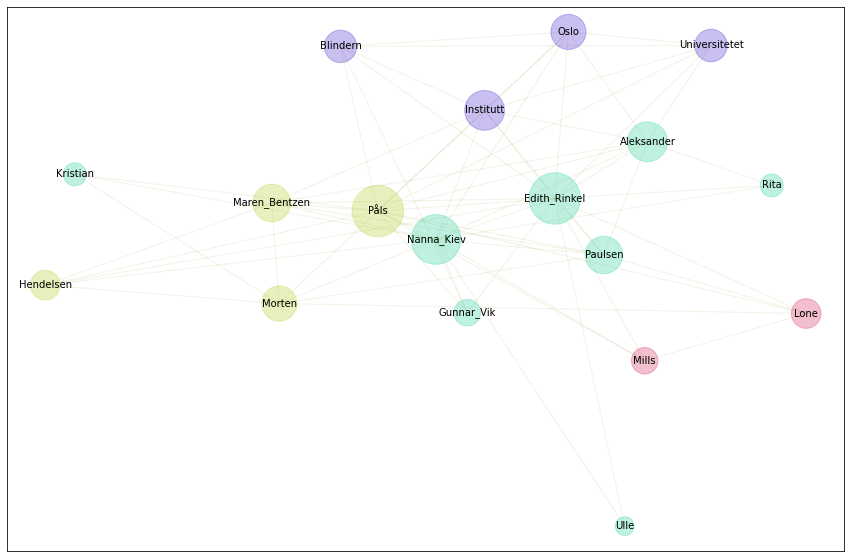

In [116]:
gnl.show_graph(G, spread = 1.8)

In [117]:
gnl.show_communities(G)

Påls-Maren_Bentzen :  Påls, Maren_Bentzen, Morten, Hendelsen

Institutt-Oslo :  Institutt, Oslo, Universitetet, Blindern

Edith_Rinkel-Nanna_Kiev :  Edith_Rinkel, Nanna_Kiev, Aleksander, Paulsen, Gunnar_Vik, Kristian, Rita, Ulle

Lone-Mills :  Lone, Mills



Dernest kan den vises og analyseres med passende kommandoer